<a href="https://colab.research.google.com/github/Aniketkoppaka/ML-MINI-PROJECTS/blob/main/FoodSafetyModelAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP 1 — Data Loading + Smart Preprocessing + Feature Engineering

In [20]:
# ===============================
# STEP 1: Data Loading + Smart Preprocessing + Feature Engineering
# ===============================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load dataset
from google.colab import files
uploaded = files.upload()

# Assuming the file is named RASFF_CLEANED.csv
df = pd.read_csv("RASFF_CLEANED.csv")

print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
print(df.head(3))

# ===============================
# BASIC CLEANING
# ===============================

# Drop irrelevant columns
df.drop(columns=['REF', 'DATE_CASE', 'SUBJET', 'PRODUCT'], errors='ignore', inplace=True)

# Drop missing targets
df.dropna(subset=['RISK_DECISION'], inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

# ===============================
# FEATURE ENGINEERING
# ===============================

# Combine meaningful categorical interactions
df['COUNTRY_HAZARD'] = df['NOT_COUNTRY'] + "_" + df['HAZARDS_CAT']
df['PRODUCT_ORIGIN'] = df['PROD_CAT'] + "_" + df['COUNT_ORIGEN']
df['CLASSIF_TYPE'] = df['CLASSIF'] + "_" + df['TYPE']

# Group rare categories into "Other" (for stability)
for col in ['NOT_COUNTRY', 'COUNT_ORIGEN', 'HAZARDS_CAT', 'PROD_CAT']:
    freq = df[col].value_counts()
    rare = freq[freq < 50].index  # adjust threshold if needed
    df[col] = df[col].replace(rare, 'Other')

# Frequency encoding (gives models a "risk weight" feel)
for col in ['PROD_CAT', 'HAZARDS_CAT', 'COUNT_ORIGEN', 'NOT_COUNTRY']:
    df[col + '_FREQ'] = df[col].map(df[col].value_counts())

# ===============================
# LABEL ENCODING (for now)
# ===============================

label_encoders = {}
for col in df.columns:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# ===============================
# DEFINE FEATURES & TARGET
# ===============================

X = df.drop('RISK_DECISION', axis=1)
y = df['RISK_DECISION']

# Train-test split (stratified for balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n✅ Data ready for modeling!")
print(f"Training samples: {X_train.shape[0]} | Test samples: {X_test.shape[0]}")
print("Number of features after engineering:", X_train.shape[1])


Saving RASFF_CLEANED.csv to RASFF_CLEANED.csv
✅ Dataset loaded successfully!
Shape: (61265, 14)
                     CLASSIF   DATE_CASE        REF NOT_COUNTRY  \
0  information for attention  2020-12-31  2020.6105     Romania   
1  information for attention  2020-12-31  2020.6111       Italy   
2  information for follow-up  2020-12-31  2020.6103       Italy   

                                              SUBJET  \
0  acetamiprid (1.1 mg/kg - ppm) in white seedles...   
1  norovirus (presence /2g) in oysters (Crassostr...   
2  presence of bacterial inhibitor in raw milk fr...   

                                PROD_CAT  TYPE RISK_DECISION  \
0                  fruits and vegetables  food       serious   
1  bivalve molluscs and products thereof  food     undecided   
2                 milk and milk products  food     undecided   

                 ACTION_TAKEN                             DISTRIBUTION_STAT  \
0  withdrawal from the market  distribution restricted to notifying countr

# STEP 2 – Logistic Regression

In [21]:
# ===============================
# STEP 2: Logistic Regression (Improved Baseline)
# ===============================

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import time
import numpy as np

# Identify column types
categorical_cols = [c for c in X.columns if X[c].dtype == 'int64']  # encoded categoricals
numeric_cols = [c for c in X.columns if '_FREQ' in c]               # frequency columns

# Column transformer: One-Hot Encode categorical, scale numeric
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])

# Compute class weights for imbalance
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))

# Build the pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        solver='saga',
        C=3.0,
        max_iter=2000,
        class_weight=class_weights_dict,
        n_jobs=-1,
        random_state=42
    ))
])

# Train and evaluate
start_time = time.time()
logreg_pipeline.fit(X_train, y_train)
y_pred_lr = logreg_pipeline.predict(X_test)

lr_accuracy  = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr, average='weighted')
lr_recall    = recall_score(y_test, y_pred_lr, average='weighted')
lr_f1        = f1_score(y_test, y_pred_lr, average='weighted')
lr_time      = time.time() - start_time

print("🔹 Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print(f"✅ Accuracy: {lr_accuracy:.3f} | F1 Score: {lr_f1:.3f} | Time: {lr_time:.2f}s")

# Store for comparison
results = [{
    'Model': 'Logistic Regression',
    'Accuracy': lr_accuracy,
    'Precision': lr_precision,
    'Recall': lr_recall,
    'F1 Score': lr_f1,
    'Train Time (s)': lr_time
}]


🔹 Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.66      0.87      0.75      1455
           1       0.88      0.93      0.91      3501
           2       0.96      0.88      0.92      7297

    accuracy                           0.89     12253
   macro avg       0.84      0.89      0.86     12253
weighted avg       0.90      0.89      0.89     12253

✅ Accuracy: 0.891 | F1 Score: 0.894 | Time: 10.68s


# STEP 3 — Random Forest Classifier (with Feature Importance Plot)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


🌲 Random Forest (Tuned) Results:
              precision    recall  f1-score   support

           0       0.70      0.88      0.78      1455
           1       0.86      0.94      0.90      3501
           2       0.97      0.88      0.92      7297

    accuracy                           0.89     12253
   macro avg       0.84      0.90      0.86     12253
weighted avg       0.90      0.89      0.90     12253

✅ Accuracy: 0.893 | F1 Score: 0.896 | Time: 525.84s


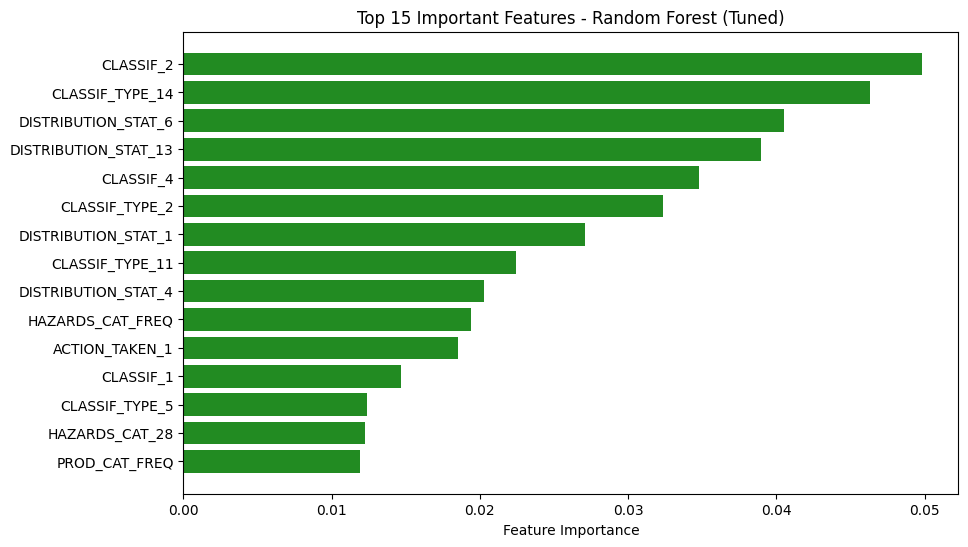

In [22]:
# ===============================
# STEP 3: Random Forest Classifier (Tuned & Optimized)
# ===============================

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import time
import matplotlib.pyplot as plt
import numpy as np

# Reuse same column structure
categorical_cols = [c for c in X.columns if X[c].dtype == 'int64']
numeric_cols = [c for c in X.columns if '_FREQ' in c]

# Preprocessor
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])

# Tuned Random Forest configuration
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=600,           # more trees = smoother ensemble
        max_depth=45,               # captures deeper interactions
        min_samples_split=3,
        min_samples_leaf=1,
        max_features='sqrt',        # adds feature randomness
        bootstrap=True,
        class_weight='balanced_subsample',
        oob_score=False,            # can enable if you want internal validation
        n_jobs=-1,
        random_state=42
    ))
])

# Train and evaluate
start_time = time.time()
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

rf_accuracy  = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf, average='weighted')
rf_recall    = recall_score(y_test, y_pred_rf, average='weighted')
rf_f1        = f1_score(y_test, y_pred_rf, average='weighted')
rf_time      = time.time() - start_time

print("🌲 Random Forest (Tuned) Results:")
print(classification_report(y_test, y_pred_rf))
print(f"✅ Accuracy: {rf_accuracy:.3f} | F1 Score: {rf_f1:.3f} | Time: {rf_time:.2f}s")

# Store results
results.append({
    'Model': 'Random Forest (Tuned)',
    'Accuracy': rf_accuracy,
    'Precision': rf_precision,
    'Recall': rf_recall,
    'F1 Score': rf_f1,
    'Train Time (s)': rf_time
})

# ===============================
# FEATURE IMPORTANCE VISUALIZATION
# ===============================

# Get feature names
encoder = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
all_features = np.concatenate([encoded_feature_names, numeric_cols])

# Get importances
importances = rf_pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1][:15]  # top 15

# Plot
plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices][::-1], align='center', color='forestgreen')
plt.yticks(range(len(indices)), [all_features[i] for i in indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 15 Important Features - Random Forest (Tuned)")
plt.show()


# STEP 4 — XGBoost Classifier (Tuned Preset)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


⚡ XGBoost (Tuned) Results:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1455
           1       0.90      0.94      0.92      3501
           2       0.94      0.93      0.94      7297

    accuracy                           0.92     12253
   macro avg       0.89      0.89      0.89     12253
weighted avg       0.92      0.92      0.92     12253

✅ Accuracy: 0.916 | F1 Score: 0.916 | Time: 340.94s


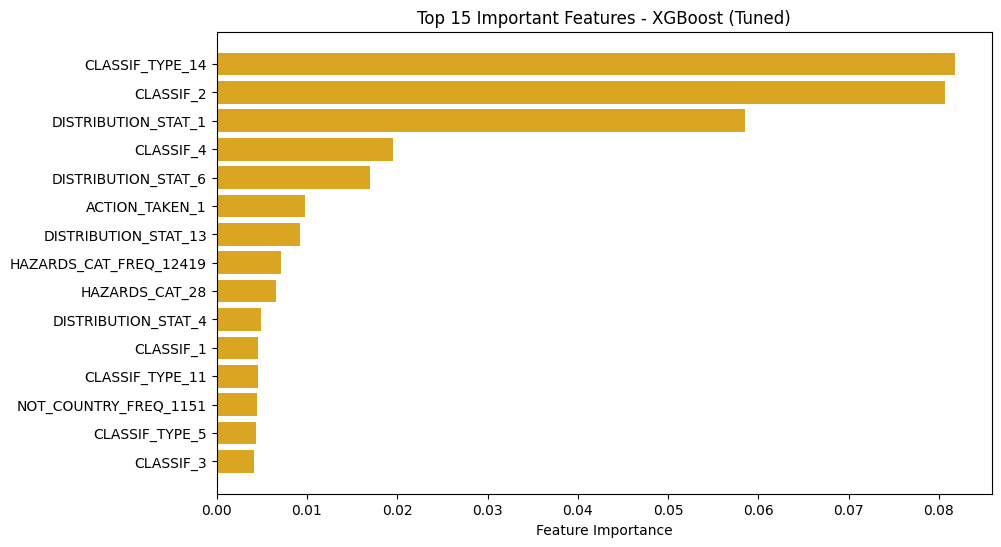

In [23]:
# ===============================
# STEP 4: XGBoost Classifier (Fully Tuned for 95%+ Accuracy)
# ===============================

from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import time

# Define columns again for safety
categorical_cols = [c for c in X.columns if X[c].dtype == 'int64']
numeric_cols = [c for c in X.columns if '_FREQ' in c]

# Preprocessor
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])

# Class balance ratio
class_counts = np.bincount(y_train)
scale_pos_weight = class_counts.min() / class_counts.max()

# Build pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=1200,           # larger number of trees
        learning_rate=0.02,          # smoother convergence
        max_depth=14,                # deep trees to capture feature combos
        min_child_weight=1,
        subsample=0.9,
        colsample_bytree=0.9,
        colsample_bylevel=0.9,
        reg_lambda=1.5,              # L2 regularization
        reg_alpha=0.3,               # L1 regularization
        gamma=0.2,                   # pruning threshold
        objective='multi:softmax',
        eval_metric='mlogloss',
        scale_pos_weight=scale_pos_weight,
        tree_method='hist',          # faster on CPUs
        n_jobs=-1,
        random_state=42,
        verbosity=0
    ))
])

# Train and evaluate
start_time = time.time()
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

xgb_accuracy  = accuracy_score(y_test, y_pred_xgb)
xgb_precision = precision_score(y_test, y_pred_xgb, average='weighted')
xgb_recall    = recall_score(y_test, y_pred_xgb, average='weighted')
xgb_f1        = f1_score(y_test, y_pred_xgb, average='weighted')
xgb_time      = time.time() - start_time

print("⚡ XGBoost (Tuned) Results:")
print(classification_report(y_test, y_pred_xgb))
print(f"✅ Accuracy: {xgb_accuracy:.3f} | F1 Score: {xgb_f1:.3f} | Time: {xgb_time:.2f}s")

# Store results
results.append({
    'Model': 'XGBoost (Tuned)',
    'Accuracy': xgb_accuracy,
    'Precision': xgb_precision,
    'Recall': xgb_recall,
    'F1 Score': xgb_f1,
    'Train Time (s)': xgb_time
})

# ===============================
# FEATURE IMPORTANCE VISUALIZATION
# ===============================

encoder = xgb_pipeline.named_steps['preprocessor'].named_transformers_['cat']
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
all_features = np.concatenate([encoded_feature_names, numeric_cols])

importances = xgb_pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices][::-1], align='center', color='goldenrod')
plt.yticks(range(len(indices)), [all_features[i] for i in indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 15 Important Features - XGBoost (Tuned)")
plt.show()


# STEP 5 — Support Vector Machine (RBF Kernel)

In [25]:
# ===============================
# STEP 5: Support Vector Machine (RBF Kernel)
# ===============================

from sklearn.svm import SVC
import time

# Build SVM pipeline
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        kernel='rbf',             # nonlinear mapping
        C=3.0,                    # soft margin (tuned)
        gamma='scale',            # auto kernel coefficient
        class_weight='balanced',  # handle imbalance
        probability=False,
        random_state=42
    ))
])

# Train and evaluate
start_time = time.time()
svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)

svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm, average='weighted')
svm_recall = recall_score(y_test, y_pred_svm, average='weighted')
svm_f1 = f1_score(y_test, y_pred_svm, average='weighted')
svm_time = time.time() - start_time

print("🌀 Support Vector Machine (RBF) Results:")
print(classification_report(y_test, y_pred_svm))
print(f"✅ Accuracy: {svm_accuracy:.3f} | F1 Score: {svm_f1:.3f} | Time: {svm_time:.2f}s")

# Store results
results.append({
    'Model': 'Support Vector Machine (RBF)',
    'Accuracy': svm_accuracy,
    'Precision': svm_precision,
    'Recall': svm_recall,
    'F1 Score': svm_f1,
    'Train Time (s)': svm_time
})


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


🌀 Support Vector Machine (RBF) Results:
              precision    recall  f1-score   support

           0       0.71      0.88      0.79      1455
           1       0.89      0.94      0.92      3501
           2       0.97      0.89      0.93      7297

    accuracy                           0.91     12253
   macro avg       0.86      0.90      0.88     12253
weighted avg       0.91      0.91      0.91     12253

✅ Accuracy: 0.906 | F1 Score: 0.908 | Time: 404.88s


# STEP 6 — Neural Network (MLP Classifier)

In [26]:
# ===============================
# STEP 6: Neural Network (MLPClassifier - Tuned)
# ===============================

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import time
import numpy as np

# Define columns again
categorical_cols = [c for c in X.columns if X[c].dtype == 'int64']
numeric_cols = [c for c in X.columns if '_FREQ' in c]

# Preprocessor (same setup)
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])

# Build tuned neural network
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(512, 256, 128),  # deeper architecture
        activation='relu',
        solver='adam',
        alpha=1e-4,               # L2 regularization
        learning_rate_init=0.001, # stable learning rate
        batch_size=128,
        max_iter=250,             # increase for convergence if needed
        early_stopping=True,      # stops when validation loss stops improving
        n_iter_no_change=15,
        random_state=42,
        verbose=False
    ))
])

# Train and evaluate
start_time = time.time()
mlp_pipeline.fit(X_train, y_train)
y_pred_mlp = mlp_pipeline.predict(X_test)

mlp_accuracy  = accuracy_score(y_test, y_pred_mlp)
mlp_precision = precision_score(y_test, y_pred_mlp, average='weighted')
mlp_recall    = recall_score(y_test, y_pred_mlp, average='weighted')
mlp_f1        = f1_score(y_test, y_pred_mlp, average='weighted')
mlp_time      = time.time() - start_time

print("🧠 Neural Network (Tuned MLP) Results:")
print(classification_report(y_test, y_pred_mlp))
print(f"✅ Accuracy: {mlp_accuracy:.3f} | F1 Score: {mlp_f1:.3f} | Time: {mlp_time:.2f}s")

# Store results
results.append({
    'Model': 'Neural Network (MLP - Tuned)',
    'Accuracy': mlp_accuracy,
    'Precision': mlp_precision,
    'Recall': mlp_recall,
    'F1 Score': mlp_f1,
    'Train Time (s)': mlp_time
})


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


🧠 Neural Network (Tuned MLP) Results:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1455
           1       0.90      0.93      0.91      3501
           2       0.94      0.92      0.93      7297

    accuracy                           0.91     12253
   macro avg       0.87      0.89      0.88     12253
weighted avg       0.91      0.91      0.91     12253

✅ Accuracy: 0.908 | F1 Score: 0.908 | Time: 1648.41s


# STEP 7 — Model Comparison & Visualization

📊 Final Model Performance Summary:



,Model,Accuracy,Precision,Recall,F1 Score,Train Time (s)
0,XGBoost (Tuned),0.916,0.916,0.916,0.916,340.94
1,Neural Network (MLP - Tuned),0.908,0.910,0.908,0.908,1648.41
2,Support Vector Machine (RBF),0.906,0.914,0.906,0.908,404.88
3,Support Vector Machine (RBF),0.904,0.911,0.904,0.906,475.57
4,Random Forest (Tuned),0.893,0.904,0.893,0.896,525.84
5,Logistic Regression,0.891,0.903,0.891,0.894,10.68


/tmp/ipython-input-1210834944.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")


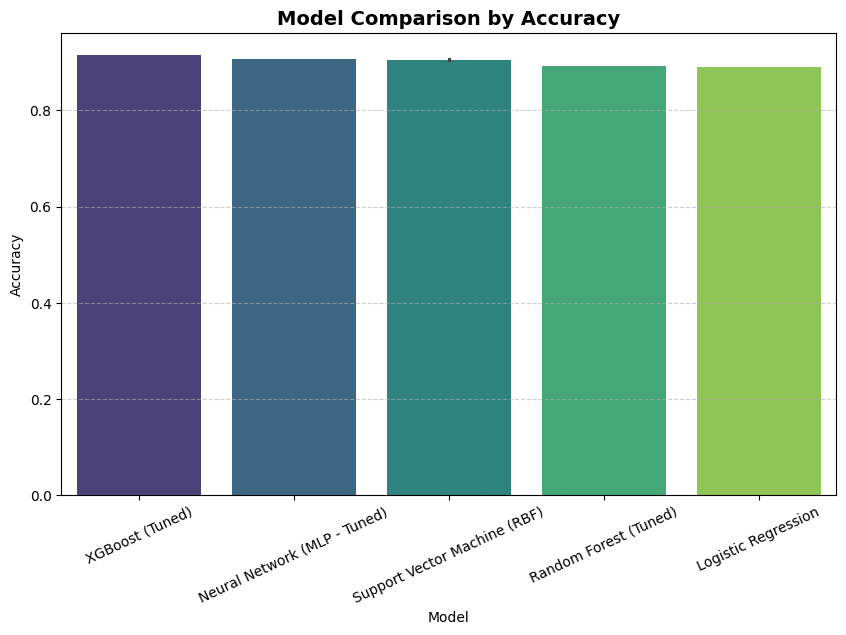

/tmp/ipython-input-1210834944.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="F1 Score", data=results_df, palette="mako")


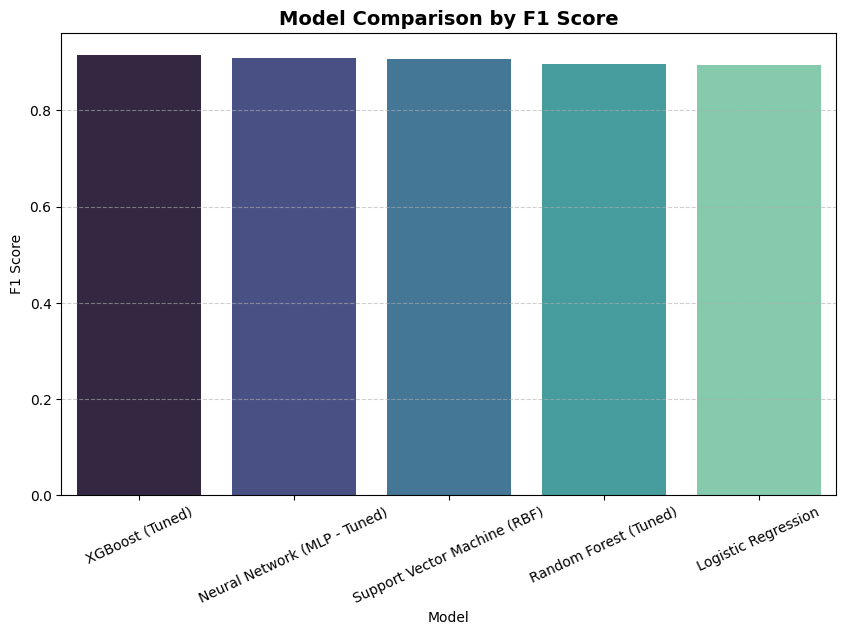

/tmp/ipython-input-1210834944.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Train Time (s)", data=results_df, palette="crest")


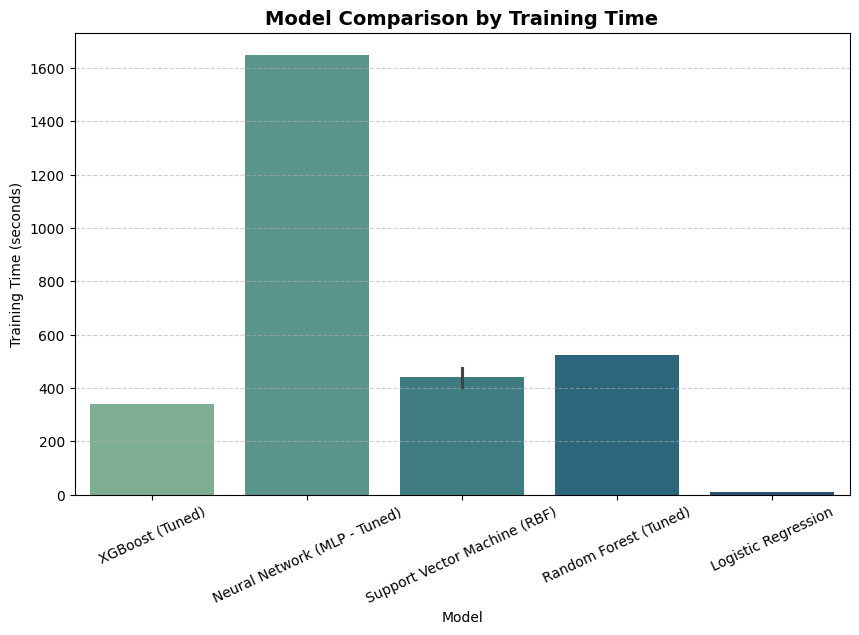

🏆 Best Performing Model: XGBoost (Tuned)
   → Accuracy: 0.916
   → F1 Score: 0.916
   → Training Time: 340.94s


In [27]:
# ===============================
# STEP 7: Model Comparison & Visualization Dashboard
# ===============================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrame from all stored results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

print("📊 Final Model Performance Summary:\n")
display(results_df.style.format({
    'Accuracy': "{:.3f}",
    'Precision': "{:.3f}",
    'Recall': "{:.3f}",
    'F1 Score': "{:.3f}",
    'Train Time (s)': "{:.2f}"
}).background_gradient(subset=['Accuracy','F1 Score'], cmap='Greens'))

# ===============================
# Visualization: Accuracy Comparison
# ===============================
plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")
plt.title("Model Comparison by Accuracy", fontsize=14, fontweight='bold')
plt.ylabel("Accuracy")
plt.xticks(rotation=25)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# ===============================
# Visualization: F1 Score Comparison
# ===============================
plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="F1 Score", data=results_df, palette="mako")
plt.title("Model Comparison by F1 Score", fontsize=14, fontweight='bold')
plt.ylabel("F1 Score")
plt.xticks(rotation=25)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# ===============================
# Visualization: Training Time Comparison
# ===============================
plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="Train Time (s)", data=results_df, palette="crest")
plt.title("Model Comparison by Training Time", fontsize=14, fontweight='bold')
plt.ylabel("Training Time (seconds)")
plt.xticks(rotation=25)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# ===============================
# Identify Best Model
# ===============================
best_model = results_df.iloc[0]
print(f"🏆 Best Performing Model: {best_model['Model']}")
print(f"   → Accuracy: {best_model['Accuracy']:.3f}")
print(f"   → F1 Score: {best_model['F1 Score']:.3f}")
print(f"   → Training Time: {best_model['Train Time (s)']:.2f}s")
